In [1]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn

from Encoder import Encoder, reparameterize
from Generator import Generator
from Discriminator import BigJointDiscriminator

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor, Compose, Resize, Normalize

from tqdm.notebook import tqdm

In [2]:
class InvertiblePriorLinear(nn.Module):
    def __init__(self):
        super(InvertiblePriorLinear, self).__init__()
        self.p = nn.Parameter(torch.rand([2]))

    def forward(self, eps):
        o = self.p[0] * eps + self.p[1]
        return o
    def inverse(self, o):
        eps = (o - self.p[1])/self.p[0]
        return eps

class InvertiblePWL(nn.Module):
    def __init__(self, vmin = -5, vmax = 5, n=100, use_bias = True):
        super(InvertiblePWL, self).__init__()
        self.p = nn.Parameter(torch.randn([n+1])/5)
        self.int_length = (vmax-vmin)/(n-1)
        
        self.n = n
        if use_bias:
            self.b = nn.Parameter(torch.randn([1])+vmin)
        else:
            self.b = vmin
        self.points = nn.Parameter(torch.from_numpy(np.linspace(vmin,vmax,n).astype('float32')).view(1,n),
                                   requires_grad = False)
    def to_positive(self,x):
        return torch.exp(x)+1e-3

    def forward(self, eps):
        delta_h = self.int_length * self.to_positive(self.p[1:self.n]).detach()
        delta_bias = torch.zeros([self.n]).to(eps.device)
                                   
        delta_bias[0] = self.b
        for i in range(self.n-1):
            delta_bias[i+1] = delta_bias[i] + delta_h[i]
        index = torch.sum(((eps-self.points)>=0).long(),1).detach() # b * 1 from 0 to n
        
        start_points = index-1
        start_points[start_points<0] = 0
        delta_bias = delta_bias[start_points]
        start_points = torch.squeeze(self.points)[torch.squeeze(start_points)].detach()
        delta_x = eps - start_points.view(-1,1)
        
        k = self.to_positive(self.p[index])
        delta_fx = delta_x*k.view(-1,1)
        
        o = delta_fx+delta_bias.view(-1,1)
        
        return o

    def inverse(self, o):
        delta_h = self.int_length * self.to_positive(self.p[1:self.n]).detach()
        delta_bias = torch.zeros([self.n]).to(o.device)
        delta_bias[0] = self.b
        for i in range(self.n-1):
            delta_bias[i+1] = delta_bias[i] + delta_h[i]
        index = torch.sum(((o-delta_bias)>=0).long(),1).detach() # b * 1 from 0 to n
        start_points = index-1
        start_points[start_points<0] = 0
        delta_bias = delta_bias[start_points]
        intervel_incre = o - delta_bias.view(-1,1)
        start_points = torch.squeeze(self.points)[torch.squeeze(start_points)].detach()
        k = self.to_positive(self.p[index])
        delta_x = intervel_incre/k.view(-1,1)
        eps = delta_x + start_points.view(-1,1)
        return eps

class InvertiblePriorInv(nn.Module):
    """docstring for InvertiblePrior"""
    def __init__(self,prior):
        super(InvertiblePriorInv, self).__init__()
        self.prior = prior
    def forward(self, o):
        return self.prior.inverse(o)
    def inverse(self, eps):
        return self.prior(eps)


class SCM(nn.Module):
    def __init__(self, d, A=None, scm_type='mlp'):
        super().__init__()
        self.d = d
        self.A_given = A
        self.A_fix_idx = A == 0
        self.A = nn.Parameter(torch.zeros(d, d))

        # Elementwise nonlinear mappings
        if scm_type=='linscm':
            prior_net_model = lambda : InvertiblePriorLinear()
            prior_net_enc_model = lambda x: InvertiblePriorInv(x)
        elif scm_type=='nlrscm':
            prior_net_model = lambda : InvertiblePWL()
            prior_net_enc_model = lambda x: InvertiblePriorInv(x)
        else:
            raise NotImplementedError("Not supported prior network.")

        for i in range(d):
            setattr(self, "prior_net%d" % i, prior_net_model())
            setattr(self, "enc_net%d" % i, prior_net_enc_model(getattr(self, "prior_net%d" % i)))

    def set_zero_grad(self):
        if self.A_given is None:
            pass
        else:
            for i in range(self.d):
                for j in range(self.d):
                    if self.A_fix_idx[i, j]:
                        self.A.grad.data[i, j].zero_()

    def prior_nlr(self, z):
        '''Nonlinear transformation f_2(z)'''
        zs = torch.split(z, 1, dim=1)
        z_new = []
        for i in range(self.d):
            z_new.append(getattr(self, "prior_net%d" % i)(zs[i]))
        return torch.cat(z_new, dim=1)

    def enc_nlr(self, z):
        '''f_2^{-1}(z)'''
        zs = torch.split(z, 1, dim=1)
        z_new = []
        for i in range(self.d):
            z_new.append(getattr(self, "enc_net%d" % i)(zs[i]))
        return torch.cat(z_new, dim=1)

    def mask(self, z): # Az
        z = torch.matmul(z, self.A)
        return z

    def inv_cal(self, eps): # (I-A)^{-1}*eps
        adj_normalized = torch.inverse(torch.eye(self.A.shape[0], device=self.A.device) - self.A)
        z_pre = torch.matmul(eps, adj_normalized)
        return z_pre

    def get_eps(self, z):
        '''Returns epsilon from f_2^{-1}(z)'''
        return torch.matmul(z, torch.eye(self.A.shape[0], device=self.A.device) - self.A)

    def intervene(self, z, z_ori):
        # f_2^{-1}(z)
        z_ori = self.enc_nlr(z_ori)
        z = self.enc_nlr(z)
        # masked nonlinear z
        z_new = self.mask(z)
        z_new = z_new + self.get_eps(z_ori)
        return self.prior_nlr(z_new)

    def forward(self, eps=None, z=None):
        if eps is not None and z is None:
            # (I-A.t)^{-1}*eps
            z = self.inv_cal(eps) # n x d
            # nonlinear transform
            return self.prior_nlr(z)
        else:
            # f_2^{-1}(z)
            z = self.enc_nlr(z)
            # mask z
            z_new = self.mask(z) # new f_2^{-1}(z) (without noise)
            return z_new, z

In [3]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [4]:
class ImageDataset(Dataset):
    def __init__(self,root_folder,transform, cols = None):
        self.transform=transform
        self.img_folder=root_folder+'img/'

        self.image_names=[i for i in os.listdir(self.img_folder) if '.jpg' in i]
        self.attr = pd.read_csv(root_folder+'attr.csv').replace(-1,0)
        _ = self.attr.pop('image_id')
        if cols is not None:
            self.attr = self.attr[cols]
        
        
        self.num_feat = len(self.attr.columns)
        self.order = list(self.attr.columns)
        
        self.attr = self.attr.values
   
    def __len__(self):
        return len(self.image_names)
 
    def __getitem__(self, index):
        image_path = self.img_folder + self.image_names[index]
        image=Image.open(image_path)
        image=self.transform(image)
        label = torch.tensor(self.attr[index], dtype = torch.float)

        return image, label

def get_train_dataloader(root_folder, img_dim=64, batch_size=32, cols = None):

    transform = Compose([Resize((img_dim, img_dim)),
                        ToTensor(),
                        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    training_data = ImageDataset(root_folder='sample_data/',transform=transform, cols = cols)
    train_dataloader = DataLoader(training_data, batch_size = batch_size)
    return train_dataloader

In [5]:
cols = ['Smiling', 'Male', 'High_Cheekbones', 'Mouth_Slightly_Open', 'Narrow_Eyes', 'Chubby']

In [6]:
root_folder = 'sample_data/'

in_channels = 3
fc_size = 2048
latent_dim = 100

img_dim = 64
batch_size = 32

num_label = len(cols)

In [7]:
train_dataloader = get_train_dataloader(root_folder, img_dim=img_dim, batch_size=batch_size, cols = cols)

In [8]:
A = torch.zeros((num_label, num_label))
A[0, 2:6] = 1
A[1, 4] = 1
A = A.to(device)

In [9]:
e = Encoder(latent_dim = latent_dim, fc_size = fc_size).to(device)
g = Generator(latent_dim = latent_dim, image_size = img_dim).to(device)
disc = BigJointDiscriminator(latent_dim = latent_dim, image_size = img_dim).to(device)

In [10]:
prior = SCM(num_label, A, scm_type='linscm').to(device)
prior_param = list(prior.parameters())
A_optimizer = optim.Adam(prior_param[0:1], lr=5e-4)
p_optimizer = optim.Adam(prior_param[1:],  lr=5e-4, betas=(0, 0.999))

In [11]:
e_optimizer = optim.Adam(e.parameters(), lr=5e-5, betas=(0, 0.999))
g_optimizer = optim.Adam(g.parameters(), lr=5e-5, betas=(0, 0.999))
d_optimizer = optim.Adam(disc.parameters(), lr=1e-4, betas=(0, 0.999))

In [12]:
num = len(train_dataloader.dataset)//batch_size

epochs = 1

In [13]:
disc_steps = 1
g_steps = 1
e_steps = 1

celoss = torch.nn.BCEWithLogitsLoss()

In [14]:
for epoch in tqdm(range(epochs)):
    disc_loss, e_loss, g_loss = [], [], []
    
    e.train()
    g.train()
    disc.train()
    
    for (X, label) in tqdm(train_dataloader, total = num):        
        X = X.to(device)
        
        sup_flag = label[:, 0] != 0
        if sup_flag.sum() > 0:
            label = label[sup_flag, :].float()
        label = label.to(device)
        
        for _ in range(disc_steps):
            disc.zero_grad()
            
            z = torch.randn(X.shape[0], latent_dim, device=device)
       
            mu, sigma = e(X)
            z_fake = reparameterize(mu, sigma )
            
            label_z = prior(z[:, :num_label])
            other_z = z[:, num_label:]
            z = torch.cat([label_z, other_z], dim=1)
            
            X_fake = g(z)
            
            e_score = disc(X, z_fake.detach())
            g_score = disc(X_fake.detach(), z.detach())
            
            del z_fake
            del X_fake
            
            loss_d = F.softplus(g_score).mean() + F.softplus(-e_score).mean()
            loss_d.backward()
            d_optimizer.step()
            disc_loss.append(loss_d.item())
            
        #___________________________________
        for _ in range(e_steps):
            z = torch.randn(X.size(0), latent_dim, device=device)
            mu, sigma = e(X)
            z_fake = reparameterize(mu, sigma )
            
            g.zero_grad()
            e.zero_grad()
            prior.zero_grad()
            
            e_score = disc(X, z_fake)
            l_encoder = e_score.mean()
            
            label_z = prior(z[:, :num_label])
            other_z = z[:, num_label:]
            z = torch.cat([label_z, other_z], dim=1)
            
            X_fake = g(z)
            label_z = mu[sup_flag, :num_label]
            sup_loss = celoss(label_z, label)
            
            l_encoder = l_encoder + sup_loss * 5
            l_encoder.backward()
            
            e_loss.append(l_encoder.item())
            e_optimizer.step()
            p_optimizer.step()
            
            g_score = disc(X_fake, z)
            s_decoder = torch.exp(g_score.detach()).clamp(0.5, 2)
            loss_decoder = -(s_decoder * g_score).mean()
            g_loss.append(loss_decoder.item())
            loss_decoder.backward()
            g_optimizer.step()
            
            prior.set_zero_grad()
            A_optimizer.step()
            p_optimizer.step()
        
    print(f"[{epoch+1}/{epochs}] Encoder Loss : {sum(e_loss)/num:>.5f} Gen Loss : {sum(g_loss)/num:>.5f} Disc Loss : {sum(disc_loss)/num:>.5f}")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/316 [00:00<?, ?it/s]

[1/1] Encoder Loss : 3.66707 Gen Loss : 0.12102 Disc Loss : 1.22369


In [17]:
def plot_image(fake):
    with torch.no_grad():
        fake = np.transpose(fake.cpu().numpy(), (0, 2, 3, 1))
    _,ax = plt.subplots(1, 10, figsize=(24,4))
    for i in range(10):
        ax[i].imshow(fake[i])
    plt.show()

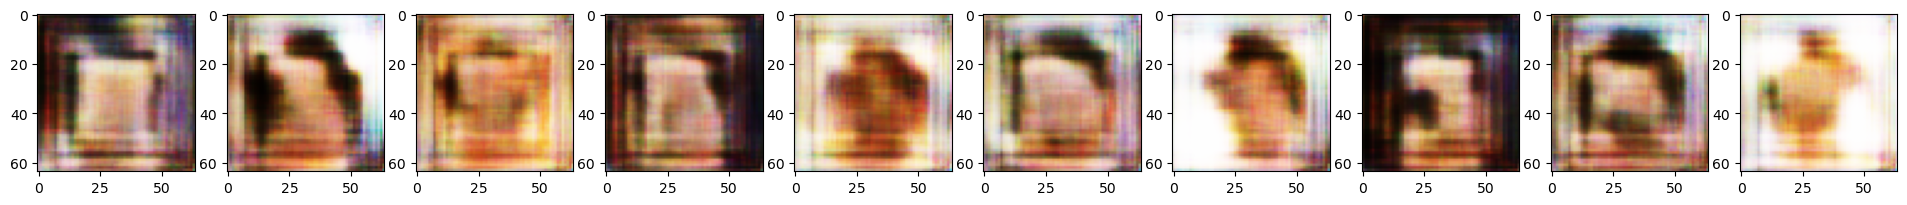

tensor([[ 0.8925,  0.0881,  0.4526,  0.7965,  0.0335,  0.6666],
        [ 0.8740,  0.2396,  0.4665,  0.9878,  0.2410,  1.0253],
        [ 0.9723, -0.1521,  0.2199,  0.6869,  0.1088,  0.7014],
        [ 0.8411,  0.0464,  0.3099,  0.7849,  0.1577,  0.9918],
        [ 0.8761,  0.0066,  0.3802,  0.8108, -0.2630,  0.3157],
        [ 0.7047, -0.1354,  0.2796,  0.7835,  0.2300,  0.6567],
        [ 0.9219, -0.0818,  0.4024,  0.6421,  0.1580,  0.7583],
        [ 0.9635, -0.3261,  0.3457,  0.5742,  0.2248,  0.7363],
        [ 0.9950, -0.1538,  0.3821,  0.5392,  0.2421,  0.9776],
        [ 0.8641,  0.0496,  0.1971,  0.6634,  0.1223,  0.4576]],
       device='mps:0', grad_fn=<SliceBackward0>) tensor([[0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0.],
        [1., 0., 1., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 1., 0., 1.],
        [0., 1., 0., 1., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
    

In [18]:
for X, label in train_dataloader:
    mu, sigma = e(X.to(device))
    z = reparameterize(mu, sigma)
    label_z = prior(z[:, :num_label])
    other_z = z[:, num_label:]
    z = torch.cat([label_z, other_z], dim=1)
    x_fake = g(z)
    x_fake = (x_fake * 0.5) + 0.5
    plot_image(x_fake)
    print(z[:10,:num_label], label[:10])
    break